In [1]:
import numpy as np
from PIL import Image
import graphviz
import automathon
from automathon import DFA, NFA
from myst_nb import glue
from IPython.display import display, SVG

(sec:regex)=

# 正規表現の基礎


何らかのテキストが与えられた時、その中に、含まれる文字列を検索することは、テキストエディタの基本的な機能となっている。このような検索機能においては、単純に`"Hello"`という文字が含まれるか、という単純なものではなく、`"H"`から始まる5文字の単語を検索したい、といったような少々曖昧な検索を行いたい場合もあるだろう。

このような場合に使うことができる**検索パターンの表現**の一種が**正規表現**である。本節では、正規表現をPythonプログラムの中で使用する方法について学ぶ。


## 正規表現とは？


**正規表現** (regular expression)とは、少し複雑な言い方をすれば**正規言語**に基づく文字表現のことを指す。正規表現の考え方は元々、神経科学分野で発生したもので、それを数学者のStephen Kleeneが**正規集合**として明確な定義を与えた。

その後、1968年になってKen Thompsonが自身の論文の中で、彼が作成したUNIX上のテキストエディタである**qed**に実装された正規表現を実現するコンパイラの仕組みについて紹介した。これが、UNIX上の文字列検索システムである**grep** (global regular expression)や**sed**へと発展した {cite}`shinya2015regex`。

現在では、多くのテキストエディタで正規表現を用いた文字列検索を使用できるほか、Pythonを含むほとんどのプログラミング言語で正規表現を用いるためのライブラリが用意されている。

Pythonにおいては標準ライブラリの`re`を通して正規表現を用いることができる。

In [2]:
import re

使用方法の一例として、以下に`"Hello, world!"`という文字列の中に`"Hello"`という文字列が含まれるかどうかを調べるプログラムを示す (これだけなら正規表現を使う必要はないが...)。

In [3]:
text = "Hello, world!"
pat = re.compile(r"Hello")
if pat.search(text):
    print("Match")
else:
    print("Not match")

Match


### raw文字列リテラル

正規表現を定義する場合、Vim等のテキストエディタやPerl等の他のプログラミング言語では`/.../`のようにスラッシュで区切られた文字列(=**正規表現リテラル**)を用いる。一方、Pythonには正規表現リテラルに類する概念はなく、通常の文字列の他、**raw文字列リテラル**によって定義することが推奨されている。

raw文字列リテラルは`r"..."`のように、クオーテーションの前に`r`を伏した文字列で定義される。まずは通常の文字列との違いを確認するために、以下の例を見てみよう。

In [4]:
print("1: '\\'")
print("2: '\t'")
print("3: '\\\t'")
print("3: '\\\\t'")

1: '\'
2: '	'
3: '\	'
3: '\\t'


この例から分かるように、バックスラッシュを入力するには文字列中で`"\\"`のように表記する必要があり、単体のバックスラッシュである`"\"`はタブ文字 (`\t`)や改行文字(`\n`)のような特殊文字を表すのに使われている。では、これを正規表現に用いようとすると何が起こるだろうか？以下のバックスラッシュとタブ文字を含む文字列に正規表現を使ってみよう。

In [5]:
text = "this\\is\t\ta\\table"
print(text)

this\is		a\table


**文字列リテラルを使う場合**

In [6]:
# 文字列リテラルの場合
p = re.compile("\t")  # タブ文字
print(p.search(text))  # -> タブ文字とマッチ
p = re.compile("\\t")  # これもタブ文字
print(p.search(text))  # -> タブ文字とマッチ
p = re.compile("\\\\t")  # "\"と"t"の2文字
print(p.search(text))  # -> "\\t"とマッチ

<re.Match object; span=(7, 8), match='\t'>
<re.Match object; span=(7, 8), match='\t'>
<re.Match object; span=(10, 12), match='\\t'>


この結果をみると、少々、予想と外れているように見えるかもしれない。特に、2番目の結果にある`"\\t"`がタブ文字とマッチしているのは不可解に見える。しかし、これは文字列の評価と正規表現の評価が二重で行なわれることに起因する現象である。

まず、`re.compile`の引数に文字列として`"\\t"`が与えられると、これが文字列として`"\"`と`"t"`の2文字である、と認識される。その後、この2文字が正規表現の評価に使われるので、`compile`関数は`"\t"`という2文字をタブ文字として解釈する。

このような、文字列評価の二重性を正しく理解していれば、上記の結果は予想の範囲内ではあるものの、より複雑な正規表現を書く場合には、特にバックスラッシュを多用することになるため、混乱が起きやすい。以上の理由から、Pythonでは、正規表現のコンパイル時にはraw文字列リテラルを用いることが強く推奨されている。

**raw文字列リテラルを使う場合**

In [7]:
# raw文字列リテラルの場合
p = re.compile(r"\t")  # タブ文字
print(p.search(text))  # -> タブ文字とマッチ
p = re.compile(r"\\t")  # "\"と"t"の2文字
print(p.search(text))  # -> "\\t"とマッチ
p = re.compile(r"\\\\t")  # "\"と”\"と"t"の3文字
print(p.search(text))  # マッチしない

<re.Match object; span=(7, 8), match='\t'>
<re.Match object; span=(10, 12), match='\\t'>
None


raw文字列リテラルを用いると、正規表現の`re.compile`関数に文字列がそのまま評価されるため、バックスラッシュの解釈がより単純になっていることが分かる。従って、特段の理由がない限りはraw文字列リテラルを用いて正規表現パターンを定義するのが良い。

### 正規表現の基本的な使い方

正規表現のパターン文字列である`pat`には指定した文字列の中に正規表現とマッチする文字列が存在するかを調べる`search`の他にも

- 文字列が正規表現と完全にマッチするかを調べる `fullmatch`
- マッチする全ての文字列を取り出す `findall`
- マッチする文字列を別の文字列に置き換える `sub`
- マッチする文字列で文章を区切る `split`

などのメソッドが用意されている。このそれぞれについて、簡単に使い方を見てみよう。

**`fullmatch`の使用例**


In [8]:
text = "Hello, world!"
pat = re.compile(r"Hello")
if pat.fullmatch(text):
    print("Match")
else:
    print("Not match")

Not match


**`findall`の使用例**


In [9]:
text = "Hello, world! Hello, Japan!"
pat = re.compile(r"Hello")
n_match = len(pat.findall(text))
print(f'There are {n_match:d} "Hello"s.')

There are 2 "Hello"s.


**`sub`の使用例**

In [10]:
text = "Hello, world! Hello, Japan!"
pat = re.compile(r"Hello")
res = pat.sub("Bonjour", text)
print(res)

Bonjour, world! Bonjour, Japan!


**`split`の使い方**

In [11]:
text = "Hello, world! Hello, Japan!"
pat = re.compile(r" ")
res = pat.split(text)
print(res)

['Hello,', 'world!', 'Hello,', 'Japan!']


:::{admonition} 正規表現の基本
:class: note

- 正規表現は特定の文字パターンに合致する文字列を探すのに用いる
- Pythonにおいては標準ライブラリの`re`を用いる
- 正規表現を定義するときは、raw文字列リテラルを用いる
:::


## 正規表現のシンタックス

ここまでの例では単純に何らかの文字列が、別の文字列に含まれるかどうかを調べてきたが、Pythonであれば、このような動作は、単純に

```python
text = "Hello, world!"
if "Hello" in text:
    print("Match")
else:
    print("Not match")
```

のように書けば十分である。

正規表現の有効性は、特定の文字列を探すことではなく、より複雑なパターンにマッチする文字列を探すことにある。以下では、正規表現パターンを定義するためのシンタックスについて基本的なものをいくつか紹介する。一方で、正規表現のシンタックスは非常に多岐に渡るため、より詳しく知りたい読者はPythonの[公式ドキュメント](https://docs.python.org/ja/3/library/re.html)を参照すると良い。


### 何らかの1文字

何らかの1文字が存在することを表したい場合には、`a.c`のように`.`を用いる。この正規表現は例えば`abc`や`adc`など、`.`の部分に何らかの1文字がはいるような文字列とはマッチするが、`abdc`のように`.`に対応する場所に2文字以上の文字が存在する場合とはマッチしない。


In [12]:
pat = re.compile("a.c")
print("PATTERN:", pat)
print(text := "abc", ":", pat.fullmatch(text))
print(text := "adc", ":", pat.fullmatch(text))
print(text := "abdc", ":", pat.fullmatch(text))

PATTERN: re.compile('a.c')
abc : <re.Match object; span=(0, 3), match='abc'>
adc : <re.Match object; span=(0, 3), match='adc'>
abdc : None


### 文字の繰り返し


何らかの文字が繰り返しているかを調べたい場合には、文字の繰り返しを表す`*`あるいは`+`を用いる。例えば、`aaabcccc`のような文字列とマッチさせたい場合`a+bc+`のように繰り返したい文字の後に`+`あるいは`*`をつける。


In [13]:
pat = re.compile("a+bc+")
print("PATTERN:", pat)

print(text := "aaabcccc", ":", pat.fullmatch(text))
print(text := "aabbcc", ":", pat.fullmatch(text))

PATTERN: re.compile('a+bc+')
aaabcccc : <re.Match object; span=(0, 8), match='aaabcccc'>
aabbcc : None


```{admonition} 「*」と「+」の違い
:class: tip

文字の繰り返しを表す`+`と`*`は、その繰り返し回数の見方に違いがある。

`+`は直前の文字が**1回以上繰り返す**場合にのみマッチするのに対し、`*`は**0回以上の繰り返し**にもマッチする。従って、

- `ab+`というパターンは`a`にはマッチせず、`ab`にはマッチする
- `ab*`というパターンは`a`にマッチし、なおかつ`ab`にもマッチする

という動作の違いがある。これらの違いについては、ぜひ読者自身で確認してみてほしい。
```

### 繰り返し回数の制限

`*`や`+`は繰り返し回数が無制限であったが、回数を制限した繰り返しを定義することもできる。例えば、`aabb`は検出したいが、`aaabb`のように`a`が3回以上繰り返す場合は検出したくない、という場合、繰り返し回数を2回以下に制限して、`a{1,2}b+`のような文字パターンを定義することができる。


In [14]:
pat = re.compile("a{1,2}b+")
print("PATTERN:", pat)
print(text := "aabb", ":", pat.fullmatch(text))
print(text := "aaabb", ":", pat.fullmatch(text))

PATTERN: re.compile('a{1,2}b+')
aabb : <re.Match object; span=(0, 4), match='aabb'>
aaabb : None


### 複数の文字列のいずれか

続いては、複数の文字列のいずれかにマッチする正規表現を紹介する。例えば、`"Hello"`と`"Bonjour"`のいずれかにマッチする正規表現は、これらの文字列を`|`で結んで`Hello|Bonjour`のように定義できる。

In [15]:
pat = re.compile("Hello|Bonjour")
print("PATTERN", pat)
print(text := "Hello, world!", ":", pat.search(text))
print(text := "Bonjour, le monde!", ":", pat.search(text))
print(text := "Hallo, welt!", ":", pat.search(text))

PATTERN re.compile('Hello|Bonjour')
Hello, world! : <re.Match object; span=(0, 5), match='Hello'>
Bonjour, le monde! : <re.Match object; span=(0, 7), match='Bonjour'>
Hallo, welt! : None


この表現は3つ以上の文字列のいずれかにマッチさせたい場合にも使用することができ、その場合は`Hello|Bonjour|Hallo`のように複数の文字列を`|`で結べば良い。

しかし、`|`は、正規表現を処理するアルゴリズムの性質上、少々計算に時間がかかる(現実的な長さの文字列ならあまり気にしなくて良いが...)ため、他の正規表現を用いて同様の表現を定義できないか考えることが大事である。

### 文字クラス


ここまでの例では、`+`や`*`といった文字の繰り返しは直前の1文字にしか適用していなかったが、**文字クラス**用いることでクラス内の任意の文字の繰り返しを定義することができる。例えば、a, b, cの三文字だけで構成された文字かどうかを調べたい場合`[abc]+`のように繰り返しに含めたい文字を`[...]`の内側に入れることで文字クラスを定義する。

In [16]:
pat = re.compile("[abc]+")
print(text := "aabbccaa", ":", pat.fullmatch(text))
print(text := "aaddccaa", ":", pat.fullmatch(text))

aabbccaa : <re.Match object; span=(0, 8), match='aabbccaa'>
aaddccaa : None


また、Python の正規表現ではUnicodeの番号が連続する文字種を用いて範囲指定できるため、例えば`[a-z]`のように書くと、小文字のアルファベット全てにマッチする文字クラスを定義することができる。

この場合、`[a-z]`のように書くと、**小文字アルファベット1文字**にマッチする文字クラスが定義され、これに繰り返しを表す`*`や`+`を追加し、`[a-z]+`のように書くことで、小文字アルファベットのみからなる文字列を検索することができる。

文字クラス内の範囲指定は複数のものを連続して書けるため、大文字小文字の全てのアルファベットにマッチさせたい場合は`[a-zA-Z]`と書けば良い。

In [17]:
pat = re.compile("[a-zA-Z]+")
print("PATTERN:", pat)
print(text := "Hello", ":", pat.fullmatch(text))
print(text := "Hi?", ":", pat.fullmatch(text))

PATTERN: re.compile('[a-zA-Z]+')
Hello : <re.Match object; span=(0, 5), match='Hello'>
Hi? : None


**除外文字クラス**

文字クラスは、**そのクラスに含まれない全ての文字**に対してマッチさせることもできる。このような除外文字のクラスを定義するには、文字クラスの先頭に`^`を付与して`[^a-z]`とする。

In [18]:
pat = re.compile("[^a-z]+")
print("PATTERN:", pat)
print(text := "Hello", ":", pat.fullmatch(text))
print(text := "HELLO", ":", pat.fullmatch(text))

PATTERN: re.compile('[^a-z]+')
Hello : None
HELLO : <re.Match object; span=(0, 5), match='HELLO'>


### 接頭辞、接尾辞


文字列の先頭から特定のパターンが出現するかどうかを調べるには、正規表現の最初に`^`を追加する。反対に、文字列の末尾に特定のパターンが出現するかどうかを調べるには、正規表現の最後に`$`を追加する。


In [19]:
# 接頭辞のチェック
pat = re.compile("^[A-Z]+.*")
print("PATTERN:", pat)
print(text := "Hello", ":", pat.fullmatch(text))
print(text := "hello", ":", pat.fullmatch(text))

PATTERN: re.compile('^[A-Z]+.*')
Hello : <re.Match object; span=(0, 5), match='Hello'>
hello : None


In [20]:
# 接尾辞のチェック
pat = re.compile(".*[a-z]+$")
print("PATTERN:", pat)
print(text := "Hello", ":", pat.fullmatch(text))
print(text := "HELLO", ":", pat.fullmatch(text))

PATTERN: re.compile('.*[a-z]+$')
Hello : <re.Match object; span=(0, 5), match='Hello'>
HELLO : None


### 最短マッチ、最長マッチ


文字の繰り返しを含む文字列を検索する場合、初期動作としては、**マッチする文字列のうち最長ものが検出される**。

例えば、`t`から始まって`e`終わるような大文字・小文字アルファベットからなる単語を検索したい場合を考えよう。この場合、正規表現のパターンを作成すると以下のようになるだろう。


In [21]:
pat = re.compile("t.+e")

この時、以下のような文字列が与えられたとする。


In [22]:
text = "I take a cup of tea."

この文字列に対して、先ほどの正規表現パターンを検索してみると、次のような結果となる。


In [23]:
print(pat.search(text))

<re.Match object; span=(2, 18), match='take a cup of te'>


これは**tから始まりeで終わる最長の文字列**を検出しているが、本来、検出したい文字列は通常`take`だろう。このように、マッチするパターンのうち、より短いパターンを検出したい場合には、繰り返しを表す`+`や`*`の後に`?`を付け加えて正規表現を定義する。

In [24]:
pat = re.compile("t.+?e")
print(pat.search(text))

<re.Match object; span=(2, 6), match='take'>


### メタ文字


プログラミング言語によって若干の違いはあるが、正規表現には事前に定義された**メタ文字**が用意されている。例えば、`\s`というメタ文字は、半角スペース (` `)、タブ (`\t`)、キャリッジリターン (`\r`)、改ページ (`\f`)、垂直タブ (`\v`)の全てにマッチする。

このようなメタ文字は、文字セットによって代替することも可能だが、数字やスペース記号は頻繁に用いる文字セットであり、メタ文字を使う方が、正規表現パターンをより短い文字列で表せるという点で優れている。

| メタ文字 | 等価な正規表現   | 説明                                               |
| :------- | :--------------- | :------------------------------------------------- |
| `\d`     | `[0-9]`          | 全ての数字にマッチする                             |
| `\D`     | `[^0-9]`         | 数字以外の全ての文字にマッチする                   |
| `\s`     | `[ \t\n\r\f\v]`  | 全てのスペース記号とマッチする                     |
| `\S`     | `[^ \t\n\r\f\v]` | 全てのスペース記号でない文字とマッチする           |
| `\w`     | `[a-zA-Z0-9_]`   | 全ての英数字とアンダースコアとマッチする           |
| `\W`     | `[^a-zA-Z0-9_]`  | 英数字とアンダースコア以外の全ての文字とマッチする |


一例として、連続するスペースやタブ文字で文字列を分解するコードは頻出である。

In [25]:
text = "Hello  world!\tHello,       Japan!"
pat = re.compile(r"\s+")
print(pat.split(text))

['Hello', 'world!', 'Hello,', 'Japan!']


### 特殊文字のエスケープ

上記の通り、正規表現では、`*`や`+`の他、`[]`や`{}`が、特殊な意味を持つことが分かる。このような特殊文字を文字列から検索するためには、バックスラッシュにより**エスケープ**する必要がある。

In [26]:
text = "1+1=2"

# エスケープなし
pat = re.compile(r"[0-9]++[0-9]+")
print(pat.search(text))  # マッチしない

# エスケープあり
pat = re.compile(r"[0-9]+\+[0-9]+")
print(pat.search(text))  # マッチ

None
<re.Match object; span=(0, 3), match='1+1'>


各文字がエスケープを必要とするかどうかは文字をエスケープした文字(=`re.escape`を使う)と元の文字が同じになるかどうかをチェックすれば良い。エスケープが必要な文字のリストは以下の通り。

In [27]:
cnt = 0
for i in range(33, 128):
    if (c := chr(i)) != re.escape(c):
        print(c, end=" ")
        cnt += 1
        if cnt % 5 == 0:
            print()

# $ & ( ) 
* + - . ? 
[ \ ] ^ { 
| } ~ 

:::{admonition} 正規表現のシンタックス
:class: note
- 正規表現には複雑な文字パターンを定義するために様々なシンタックスが存在する
- 文字クラスを用いると、複数の文字のいずれか一つを表すことができる
- 文字クラスと繰り返し記号(`*`や`+`)を用いると、特定の文字種のみからなる文字列を検索できる
- 正規表現の定義に用いられる特殊文字を検索したい場合にはエスケープをする必要がある
:::

## 非決定性有限オートマトン


現在、正規表現を処理するための仕組みには大きく分けて**非決定性有限オートマトン** (NFA, non-deterministic finite automaton)に基づく**NFA型**と、**バックトラッキング法**に基づく**VM型** (VMはVirtual Machineの略)の2つがある。現在、多くの言語では、表現の柔軟性から後者のVM型の正規表現解析法が使われており、Pythonの正規表現もVM型を採用している {cite}`felix2014understanding`。

その一方、前述のThompsonによる正規表現はNFA型を採用していたこともあり、正規表現を理解する上でNFAの理解は避けては通れない。ここでは、NFAを用いた正規表現の解析法について、簡単に紹介する。

### 有限オートマトン

**オートマトン**とは、計算機を単純化したモデルの一つであり、**状態**と、状態遷移を表す**規則**からなる。オートマトンは、この状態と規則を元に入力の文字列を読み取る動作を定義する。

例えば、aとbからなる*何らかの*文字列を読み取るオートマトンは次のように定義される。

In [28]:
q = {"q0", "q1"}
sigma = {"a", "b"}
delta = {"q0": {"a": "q1"}, "q1": {"b": "q0"}}

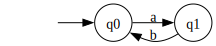

In [29]:
initial_state = "q0"
accept_state = {}

automata = automathon.DFA(q, sigma, delta, initial_state, accept_state)
automata.view(file_name="dfa")

g = graphviz.Source.from_file("dfa.gv")
g.render(format="svg")
with open("dfa.gv.svg", "rb") as f:
    svg = SVG(f.read())

glue("auto01", svg)

:::{glue:figure} auto01
:name: auto01
:width: 50%

有限オートマトンの例
:::

このオートマトンは`q0`と`q1`の2つの状態を持ち、文字`a`あるいは`b`を読み取ると、二つの状態の間で遷移が起こる。初期状態は`q0`であり、このオートマトンは`ababa...`のような`a`と`b`が交互に現れるような文字列を読み取る。

オートマトンには受理状態と呼ばれる最終状態を定義することができ、以下のように二重丸で示した状態を受理状態であると見なす。

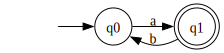

In [30]:
initial_state = "q0"
accept_state = {"q1"}

automata = automathon.DFA(q, sigma, delta, initial_state, accept_state)
automata.view(file_name="dfa")

g = graphviz.Source.from_file("dfa.gv")
g.render(format="svg")
with open("dfa.gv.svg", "rb") as f:
    svg = SVG(f.read())

glue("auto02", svg)

:::{glue:figure} auto02
:name: auto02
:width: 50%

受理状態を持つ有限オートマトン
:::

この例では状態`q1`が受理状態であり、文字列の終端まで読み取った時に状態が`q1`であれば文字列が受理される。従って、このオートマトンでは`ababab`という文字列は受理されるが、`ababa`という文字列は棄却される。

オートマトンのうち状態の数が有限であるものを特に**有限オートマトン**と呼ぶ。

### 決定性と非決定性

{ref}`先ほどの例<auto02>`に示したオートマトンは入力が与えられると決定論的に文字列が読み取られていくという特徴があり、入力文字列に対して状態遷移が一意に決まる。このような動作が決定的な有限オートマトンのことを**決定性有限オートマトン** (DFA, deterministic finite automaton)と呼ぶ。

DFAのより複雑な例として、`a`と`b`だけからなる文字列(今回は`a`と`b`が繰り返しても良い)を受理するとDFAは以下のように表せる。

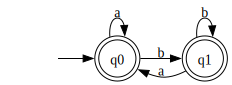

In [31]:
q = {"q0", "q1"}
sigma = {"a", "b"}
delta = {"q0": {"a": "q0", "b": "q1"}, "q1": {"a": "q0", "b": "q1"}}

initial_state = "q0"
accept_state = {"q0", "q1"}

automata = automathon.DFA(q, sigma, delta, initial_state, accept_state)
automata.view(file_name="dfa")

g = graphviz.Source.from_file("dfa.gv")
g.render(format="svg")
with open("dfa.gv.svg", "rb") as f:
    svg = SVG(f.read())

glue("auto03", svg)

:::{glue:figure} auto03
:name: auto03
:width: 50%

より複雑な決定性有限オートマトン
:::

一方で、入力の文字列に対して、状態遷移が一意に定まらない有限オートマトンもあり、これを**非決定性有限オートマトン** (NFA, non-deterministic finite automaton)と呼ぶ。最も代表的な例は、後ろから何番目かに特定の文字が存在するかどうかを調べる有限オートマトンである。

今、文字列が`a`と`b`の2文字から構成されていて、最後から3番目に`b`が存在するかどうかを調べる有限オートマトンを考える。この有限オートマトンは以下のように表現できる。

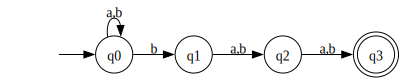

In [32]:
q = {"q0", "q1", "q2", "q3"}
sigma = {"a", "b"}
delta = {
    "q0": {
        "a,b": "q0",
        "b": "q1"
    },
    "q1": {
        "a,b": "q2"
    },
    "q2": {
        "a,b": "q3"
    }
}

initial_state = "q0"
accept_state = {"q3"}

automata = automathon.DFA(q, sigma, delta, initial_state, accept_state)
automata.view(file_name="dfa")

g = graphviz.Source.from_file("dfa.gv")
g.render(format="svg")
with open("dfa.gv.svg", "rb") as f:
    svg = SVG(f.read())

glue("auto04", svg)

:::{glue:figure} auto04
:name: auto04
:width: 90%

非決定性有限オートマトンの例
:::

この有限オートマトンは、一度、文字`b`が読み取られて状態が`q1`に遷移すると、そこから`a`, `b`のいずれかの文字を2文字読み取って受理状態である`q3`に遷移する。従って、`b`という文字が後ろから3番目にある文字列が受理されることが分かる。

この例で注目すべきは、上記の有限オートマトンが状態`q0`において文字`a`が与えられた時に、状態`q0`自身への遷移と状態`q1`への遷移が存在する、という点である。このように、特定の文字列に対して複数の遷移が存在するのが非決定性有限オートマトンの特徴である。

### 正規表現との関係

先ほどの{ref}`NFAの例<auto04>`のように、最後から3番目に文字`b`が存在するかどうかを調べる正規表現は`[ab]*b[ab][ab]`のように書ける。

実際のところ、正規表現パターンのうち`|`と`*`だけを含むようなものは非決定性有限オートマトンと等価である。これは`a|b`のような正規表現が`a`あるいは`b`を読み取って自身以外の状態へと遷移する動作を、`a*`のような正規表現が文字`a`を読み取って自身へと遷移する動作を表すことを考えれば自然である。

また、より複雑な正規表現も、実は`|`と`*`だけを使えば表すことができ、`a+`は`aa*`と等価であるし、`[ab]*`は`(a|b)*`と等価である。以上から、正規表現と非決定性有限オートマトンの等価性が伺える。

しかし、ここまでの議論は演繹的な議論であり、より厳密に等価性を議論するには、数学的に有限オートマトンを定義する必要がある。詳細に興味のある読者は参考文献に挙げた資料を参照してみてほしい。

:::{admonition} 正規表現と非決定性有限オートマトン
:class: note

- 現在の正規表現エンジンには非決定有限オートマトンに基づくNFA型とバックトラック法に基づくVM型がある
- 有限オートマトンには決定性有限オートマトンと非決定性有限オートマトンがある
- 決定性と非決定性は、特定の文字列が与えられた時の遷移先が一意に決まるか否かで決まる
- 正規表現は非決定性有限オートマトンと等価なものとして定義できる
:::

## サブグループ


正規表現でマッチした文字列の全体及び一部を取り出す方法に**サブグループ**を用いる方法がある。サブグループは正規表現内で括弧`(...)`を使うことで定義でき、その内部に記述した正規表現とマッチしたサブグループには、先頭から順に1から番号が振られる。

サブグループに対応する文字列は`search`や`fullmatch`の戻り値である`Match`型の変数に対して、サブグループの番号を与えることで取得できる。

In [33]:
text = '<a href="http://www.google.com" alt="google">Google</a>'
pat = re.compile(r'<a .*href="(\S+?)".*>(\S+?)</a>')
match = pat.fullmatch(text)
print(f"full: {match[0]:s}")
print(f"sub#1: {match[1]:s}")
print(f"sub#2: {match[2]:s}")

full: <a href="http://www.google.com" alt="google">Google</a>
sub#1: http://www.google.com
sub#2: Google


上記の例では、ハイパーリンクを定義したHTMLタグから、リンク先のURLとリンク文字列を抜き出している。この例で、`href="(\S+.)"`の部分でリンク先のURLを、`<a ...>(\S+?)</a>`の部分でリンク文字列を、それぞれ取り出している。

### 名前付きサブグループ

より複雑な例を扱う場合には、それぞれのサブグループに名前をつけることもできる。サブグループに名前をつけるには、サブグループを定義する括弧`(...)`の先頭に`(?P<name>...)`のように名前の定義を記述する。上記の例で各サブグループに名前をつけると以下のようになる。

In [34]:
text = '<a href="http://www.google.com" alt="google">Google</a>'
pat = re.compile(r'<a .*href="(?P<url>\S+?)".*>(?P<text>\S+?)</a>')
match = pat.fullmatch(text)
print(f"full: {match[0]:s}")
print(f"url: {match['url']:s}")
print(f"text: {match['text']:s}")

full: <a href="http://www.google.com" alt="google">Google</a>
url: http://www.google.com
text: Google


また、かなり複雑な例にはなるが、サブグループは階層的に定義することもできて、以下の例のように、HTMLタグの属性の書式が正しいかを調べることができる。

In [35]:
text = '<a href="http://www.google.com" alt="google">Google</a>'
pat = re.compile(
    r'<a(\s*(?P<field>\S+?)="(?P<value>\S+?)")*>(?P<text>.+?)</a>')
match = pat.fullmatch(text)
print(f"full: {match[0]:s}")

full: <a href="http://www.google.com" alt="google">Google</a>


ただし、サブグループはマッチした最後の文字列を取り出すため、上記の例では`href="..."`の部分を取り出すことはできず、名前付きサブグループで該当する文字列を取り出すと、`alt="..."`の部分だけが取り出される。

In [36]:
print(match.groupdict())

{'field': 'alt', 'value': 'google', 'text': 'Google'}


### 文字列の置き換え

サブグループは、文字列の置き換えにおいても強力なツールである。例えば、英語から日本語の書き換えの際に、`Section 1`という文字列を`第1節`のように書き換えたいとする。

この場合、`Section 1`に対応する正規表現は`[Ss]ection\s*?([0-9]+)`のような書式になる。この正規表現パターンに対して`sub`関数を用いて文字列の置き換えを行う場合、マッチしたサブグループは`\1`のように**バックスラッシュ+数字**のような形で参照できる。

In [37]:
pat = re.compile(r"[Ss]ection\s*?([0-9]+?)")
print(text := "Section 1", "->", pat.sub(r"第\1節", text))
print(text := "section99", "->", pat.sub(r"第\1節", text))

Section 1 -> 第1節
section99 -> 第9節9


名前付きサブグループを使う場合には、`\g<name>`のように書いてサブグループの名前を指定できる。

In [38]:
pat = re.compile(r"[Ss]ection\s*?(?P<index>[0-9]+)")
print(text := "section  123", "->", pat.sub(r"第\g<index>節", text))

section  123 -> 第123節


:::{admonition} サブグループ
:class: note

- 正規表現の中で `(...)`のように書くことでサブグループを定義できる
- サブグループ内の正規表現にマッチした文字列は`match[1]`のような形で取り出せる
- サブグループには`(?P<name>...)`のような形で名前をつけることもできる
- サブグループにマッチした文字列は`\1`や`\g<name>`のような形で文字列の置き換えにも利用できる
:::

## 日本語の取り扱い


結論から言うと、**日本語を取り扱うために意識しなければならないことはほとんどない**。例えば、とある日本語の文章に「こ」から始まり「は」で終わる5文字の言葉が含まれているかどうかを知りたいとする。

ここまでの復習的な内容だが、「こ」や「は」が日本語の文字であるということを特別視しなければ、上記の条件に合う正規表現を導くことは容易だろう。正解は以下のようになる (初期状態ではセルを非表示にしてある)。

In [39]:
pat = re.compile(r"こ.{3}は")
text = "こんにちは こんばんわ こんばんは"
matches = pat.findall(text)
print(matches)

['こんにちは', 'こんばんは']


しかし、日本語と英語が混じった文章もあるかもしれない。次のような場合はどうだろうか？

In [40]:
pat = re.compile(r"こ.{3}は")
text = "こんにちは。あのこ、AIは得意だって。"
matches = pat.findall(text)
print(matches)

['こんにちは', 'こ、AIは']


もちろん、上記のような動作を想定して正規表現を使っているかもしれないが、日本語だけ、もっというとひらがなだけで構成された「こ」で始まり、「は」で終わる5文字の言葉を探したいかもしれない。

実は、日本語のひらがなやカタカナは、Unicodeによって整理されており、これを用いると、英数字なのか平仮名なのか、といった文字種を判別することができる。Unicode上のひらがなは小文字の「ぁ」(`0x3041`)から「ゔ」(`0x3094`)までに定義されていて、一覧にすると以下のようになる。

In [41]:
for i, c in enumerate(range(0x3041, 0x3094 + 1)):
    print(chr(c), end="")
    if (i + 1) % 10 == 0:
        print()

ぁあぃいぅうぇえぉお
かがきぎくぐけげこご
さざしじすずせぜそぞ
ただちぢっつづてでと
どなにぬねのはばぱひ
びぴふぶぷへべぺほぼ
ぽまみむめもゃやゅゆ
ょよらりるれろゎわゐ
ゑをんゔ

同じようにカタカナは「ァ」(`0x30A1`)から「ヴ」(`0x30F4`)までに定義されており、一覧にすると以下のようになる。


In [42]:
for i, c in enumerate(range(0x30A1, 0x30F4 + 1)):
    print(chr(c), end="")
    if (i + 1) % 10 == 0:
        print()

ァアィイゥウェエォオ
カガキギクグケゲコゴ
サザシジスズセゼソゾ
タダチヂッツヅテデト
ドナニヌネノハバパヒ
ビピフブプヘベペホボ
ポマミムメモャヤュユ
ョヨラリルレロヮワヰ
ヱヲンヴ

Unicodeを用いると、ひらがな全体を表す文字クラスは`[\u3041-\u3094]`のように表すことができる。先ほどまでは16進数であることを表すために`0x`という接頭辞を用いていたが、正規表現中では代わりに`\u`という接頭辞を使う。

この例では、文字クラスが、ある意味で**数値の範囲**として表されているわけだが、ここで何か気がつくことはあるだろうか。実は、`[A-Z]`のような文字クラスも`A`や`Z`などを符号付き8bit整数としてUnicodeの範囲を示す数字として扱っていたに過ぎないのである。

ここまでを踏まえると、Unicodeを用いれば、「こ」で始まり「は」で始まるひらがな5文字の言葉を探す正規表現は以下のようになる。

In [43]:
pat = re.compile(r"こ[\u3041-\u3094]{3}は")
text = "こんにちは。あのこ、AIは得意だって。"
matches = pat.findall(text)
print(matches)

['こんにちは']


この際、Pythonの文字列は**そもそもとして文字列中の各文字をUnicodeで扱っている**ので、ひらがなやカタカナそれ自体を文字セットの下限と上限を指定するのに用いても問題ない。

In [44]:
pat = re.compile(r"こ[ぁ-ゔ]{3}は")
text = "こんにちは。あのこ、AIは得意だって。"
matches = pat.findall(text)
print(matches)

['こんにちは']


また、一般的な漢字は「一」(`0x4E00`)から「鿿」(`0x9FFF`)の範囲にある約2万文字がCJK統合漢字としてまとめられている。従って、日本語に使われうる文字を全て検出するには、`[\u3041-\u3094\u30A1-\u30F4\u4E00-\u9FFF]`のような文字クラスを用いれば良い。

しかし、このような日本語文字のUnicodeや文字の範囲を覚えるのはなかなか大変である。実は、Pythonの`re`と互換性のあるサードバーティ製のライブラリに`regex`があり、このライブラリを用いると、ひらがな、カタカナ、漢字を含む文字クラスはそれぞれ以下のようになる。

In [45]:
import regex

hira = regex.compile(r"\p{Hiragana}")
kata = regex.compile(r"\p{Katakana}")
kanji = regex.compile(r"\p{Han}")

実際に`regex`ライブラリを用いて、上記の「こ、から始まり、は、で終わる5文字の単語」を取り出してみる。

In [46]:
pat = regex.compile(r"こ\p{Hiragana}{3}は")
text = "こんにちは。あのこ、AIは得意だって。"
matches = pat.findall(text)
print(matches)

['こんにちは']


こちらのライブラリはサードパーティ製なので、別途インストールが必要ではあるものの、Unicodeの範囲を指定するよりは、表記も分かりやすいだろう。

:::{admonition} 日本語の取り扱い
:class: note

- Pythonでは日本語を扱うために特別意識することはない
- ただし、ひらがなだけ、カタカナだけ、といった場合を扱うには文字クラスの定義が必要
- 日本語を扱う文字クラスはUnicodeで範囲を指定して定義する
- サードパーティ製の`regex`ライブラリを用いると簡単に文字クラスが定義できる。
:::

## 練習問題


```{card}
**問1**
^^^
正規表現を用いて、HTML タグから、タグ名、id、class の情報を取り出す関数を作成せよ。その際、id と class の指定順序は順不同であるほか、それ以外の属性値 (`align="center"`など)が指定されている場合もあることに注意せよ。
```

In [47]:
# 問1
def Q1(text: str):
    pat = re.compile("<(?P<tag>[a-z]+?)\s+?(?P<fields>.+)>")
    match = pat.search(text)
    tag = match["tag"]
    fields = match["fields"]

    pat = re.compile('(?P<key>\S+?)="(?P<value>\S+?)"')
    matches = pat.findall(fields)
    fields = {k: v for k, v in matches}

    id = None
    if "id" in fields:
        id = fields["id"]
    cls = None
    if "class" in fields:
        cls = fields["class"]

    return tag, id, cls

In [48]:
input = '<div id="container" class="main">'
output = Q1(input)
glue("input1-1", input)
glue("output1-1", output)

'<div id="container" class="main">'

('div', 'container', 'main')

* **入力例1:** {glue:text}`input1-1`
* **出力例1:** {glue:text}`output1-1`

In [49]:
input = '<div class="form" align="center">'
output = Q1(input)
glue("input1-2", input)
glue("output1-2", output)

'<div class="form" align="center">'

('div', None, 'form')

* **入力例2:** {glue:text}`input1-2`
* **出力例2:** {glue:text}`output1-2`

```{card}
**問2**
^^^
日本語の文章が与えられたとき、漢字の四字熟語だけを正規表現を用いて取り出す関数を作成せよ。この際、四字より多い感じから構成される熟語 (例: 日常茶飯事、日々是好日)を取り出さないようにすること。
```

In [50]:
def Q2(text):
    pat = re.compile("[\u4E00-\u9FFF]{4,}")
    matches = pat.findall(text)
    matches = [m for m in matches if len(m) == 4]
    return matches

In [51]:
input = "だんだんと暖かくなってきました。これが三寒四温ですね。"
output = Q2(input)
glue("input2-1", input)
glue("output2-1", output)

'だんだんと暖かくなってきました。これが三寒四温ですね。'

['三寒四温']

* **入力例1:** {glue:}`input2-1`
* **出力例1:** {glue:}`output2-1`

In [52]:
input = "彼の遅刻は日常茶飯事です。"
output = Q2(input)
glue("input2-2", input)
glue("output2-2", output)

'彼の遅刻は日常茶飯事です。'

[]

* **入力例2:** {glue:}`input2-2`
* **出力例2:** {glue:}`output2-2`

## 参考文献

```{bibliography}
:filter: docname in docnames
```